<a href="https://colab.research.google.com/github/NolanRink/CS4540/blob/main/HW15/HW15_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility (optional)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation: resize images to 64x64 and normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training set
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]


In [2]:
# Generator: input is (latent_dim x 1 x 1), output is (1 x 64 x 64)
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: (512 x 4 x 4)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: (256 x 8 x 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: (128 x 16 x 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: (64 x 32 x 32)
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: (1 x 64 x 64)
        )

    def forward(self, input):
        return self.main(input)

# Discriminator: input is (1 x 64 x 64), output is probability scalar
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 64 x 64
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (64 x 32 x 32)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (128 x 16 x 16)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (256 x 8 x 8)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (512 x 4 x 4)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output: (1 x 1 x 1) scalar probability
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Create the networks
latent_dim = 100
netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)


In [3]:
# Custom weight initialization called on network weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply initialization
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [4]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
G_losses = []
D_losses = []

print("Starting Training Loop...")
num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for i, (real_images, _) in enumerate(dataloader):
        netD.zero_grad()
        # Train with real images
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        label_real = torch.full((batch_size,), 1.0, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label_real)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.full((batch_size,), 0.0, device=device)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label_fake)
        errD_fake.backward()
        optimizerD.step()

        # Update generator
        netG.zero_grad()
        label_gen = torch.full((batch_size,), 1.0, device=device)  # want D to label fakes as real
        output = netD(fake_images)
        errG = criterion(output, label_gen)
        errG.backward()
        optimizerG.step()

        # Record losses
        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item())


Starting Training Loop...
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


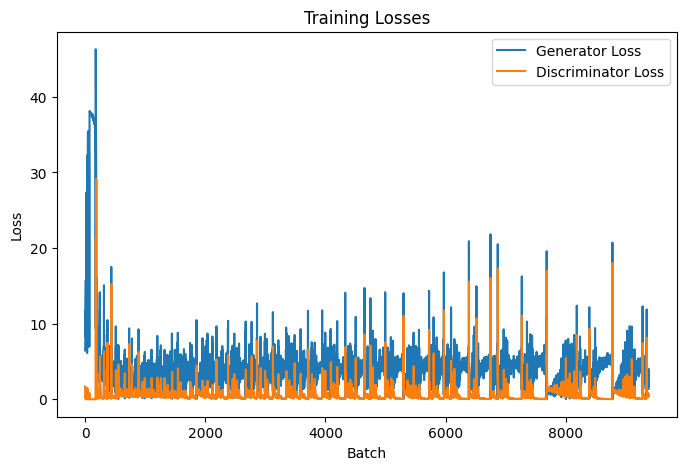

In [5]:
# Plot the generator and discriminator losses
plt.figure(figsize=(8,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.title("Training Losses")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()


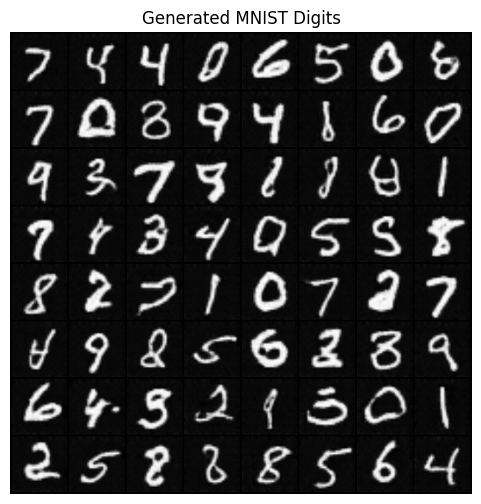

In [6]:
# Generate a batch of fake images for visualization
netG.eval()  # switch to evaluation mode
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

# Make a grid of images
fake_grid = utils.make_grid(fake_images, padding=2, normalize=True)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(np.transpose(fake_grid, (1,2,0)), cmap='gray')
plt.title("Generated MNIST Digits")
plt.show()


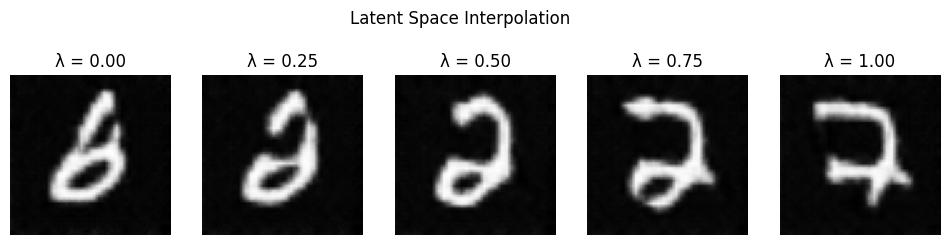

In [7]:
netG.eval()
z0 = torch.randn(1, latent_dim, 1, 1, device=device)
z1 = torch.randn(1, latent_dim, 1, 1, device=device)
num_interp = 5
lam_vals = np.linspace(0, 1, num_interp)

interp_images = []
for lam in lam_vals:
    z_interp = (1 - lam) * z0 + lam * z1
    with torch.no_grad():
        img = netG(z_interp).detach().cpu().squeeze()
    interp_images.append(img)

# Plot interpolated images
plt.figure(figsize=(12, 3))
for i, lam in enumerate(lam_vals):
    plt.subplot(1, num_interp, i+1)
    plt.imshow(interp_images[i], cmap='gray')
    plt.title(f"λ = {lam:.2f}")
    plt.axis("off")
plt.suptitle("Latent Space Interpolation")
plt.show()
